In [ ]:
pip install ensemble_boxes

In [1]:
import cv2
import numpy as np
from ensemble_boxes import *
from pycocotools.coco import COCO
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
def print_img(test_dir, image_ids, file_number, model_name, classes, color, submission_df, x):
    if file_number == 0:
        print('insert submission_df')
        return
    elif file_number == 1:
        fig, axes = plt.subplots(nrows = 1, ncols = file_number, figsize = (40,20))
        img_path = test_dir + image_ids[x]
        test_img = Image.open(img_path)
        img = np.array(test_img)
#         for k in range(file_number):
        info = submission_df[0]['PredictionString'][x].strip()
        info = info.split(" ")
        i = 0
        axes.imshow(img)
        axes.set_title(model_name, loc='left', fontsize=15)
        axes.axis('off')
        while i < len(info):
            label = int(info[i])
            score = float(info[i+1])
            x_min = float(info[i+2])
            y_min = float(info[i+3])
            x_max = float(info[i+4])
            y_max = float(info[i+5])
            axes.add_patch(
                 patches.Rectangle(
                    (x_min, y_min),
                    x_max-x_min,
                    y_max-y_min,
                    edgecolor = color[label],
                    facecolor = 'red',
                    fill=False,
                    linewidth=4, 
                    alpha=1.0
                 ))
            axes.text(x_min+1.5, y_min-5.0, classes[label], fontsize=15, color = 'white', backgroundcolor=color[label], alpha=0.5)
            i += 6
        plt.show()
    elif file_number >= 2:   
        fig, axes = plt.subplots(nrows = 1, ncols = file_number, figsize = (40,20))
        img_path = test_dir + image_ids[x]
        test_img = Image.open(img_path)
        img = np.array(test_img)
        for k in range(file_number):
            info = submission_df[k]['PredictionString'][x].strip()
            info = info.split(" ")
            i = 0
            axes[k].imshow(img)
            axes[k].set_title(model_name[k], loc='left', fontsize=15)
            axes[k].axis('off')
            while i < len(info):
                label = int(info[i])
                score = float(info[i+1])
                x_min = float(info[i+2])
                y_min = float(info[i+3])
                x_max = float(info[i+4])
                y_max = float(info[i+5])
                axes[k].add_patch(
                     patches.Rectangle(
                        (x_min, y_min),
                        x_max-x_min,
                        y_max-y_min,
                        edgecolor = color[label],
                        facecolor = 'red',
                        fill=False,
                        linewidth=4, 
                        alpha=1.0
                     ))
                axes[k].text(x_min+1.5, y_min-5.0, classes[label], fontsize=15, color = 'white', backgroundcolor=color[label], alpha=0.5)
                i += 6
        plt.show()

In [3]:
cd ddd

[Errno 2] No such file or directory: 'ddd'
/opt/ml/code/mmdetection_trash


In [4]:
# change this block #
csv1 = './kfold/jh_best.csv'
csv2 = './kfold/kfold0_LB0.5142.csv'
csv3 = './kfold/kfold2_LB0.5247.csv'
csv4 = './kfold/kfold3_LB5206.csv'
csv5 = './kfold/kfold4_LB0.5395.csv'
submission_files = [csv1, csv2, csv3, csv4, csv5]
# submission_files = [csv1]
# change this block #

# submission_files = [csv1]
model_name = [file_name.split('/')[-1] for file_name in submission_files]
submission_df = [pd.read_csv(file) for file in submission_files]


In [5]:
# result initialize
result_df = []
result_model_name = []
result_file_number = 0

In [6]:
image_ids = submission_df[0]['image_id'].tolist()

test_dir = '../../input/data/'
annotation = '../../input/data/test.json'
coco = COCO(annotation)

# bounding box 확인하기
# color = ['#E89D9D', '#FFADAD', '#FFD6A5', '#FDFFB6', '#CAFFBF', '#9BF6FF', '#A0C4FF', '#BDB2FF', '#FFADFF', '#023E8A', '#03045E']
color = ['#FF595E', '#FFB485', '#F5B400', '#D0D449', '#6A9A1D', '#76BA4F', '#366D4D', '#269BE3', '#324F85', '#7E5DAC', '#792E3F']
classes = ["UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass",
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
prediction_strings = []
file_names = []
# change this block #
iou_thr = 0.8
type_nms = 'nms'
weights = [2, 1, 1, 2, 1]
# change this block #

for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        if len(predict_list)==0 or len(predict_list)==1:
            continue
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    if len(boxes_list):
        # change this block #
        if type_nms == 'wbf':
            boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=0.00001)
        elif type_nms == 'nms':
            boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        elif type_nms == 'soft_nms':
            boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        # change this block #
        
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

In [8]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
# change this block #
csv = f'./kfold/{type_nms}_{iou_thr}.csv'
# change this block #

# original image with result #
submission.to_csv(csv, index=False)
submission_df.append(submission)
model_name.append(csv.split('/')[-1])
file_number = len(submission_df)

# only result image #
result_df.append(submission)
result_model_name.append(csv.split('/')[-1])
result_file_number += 1

# submission.head()

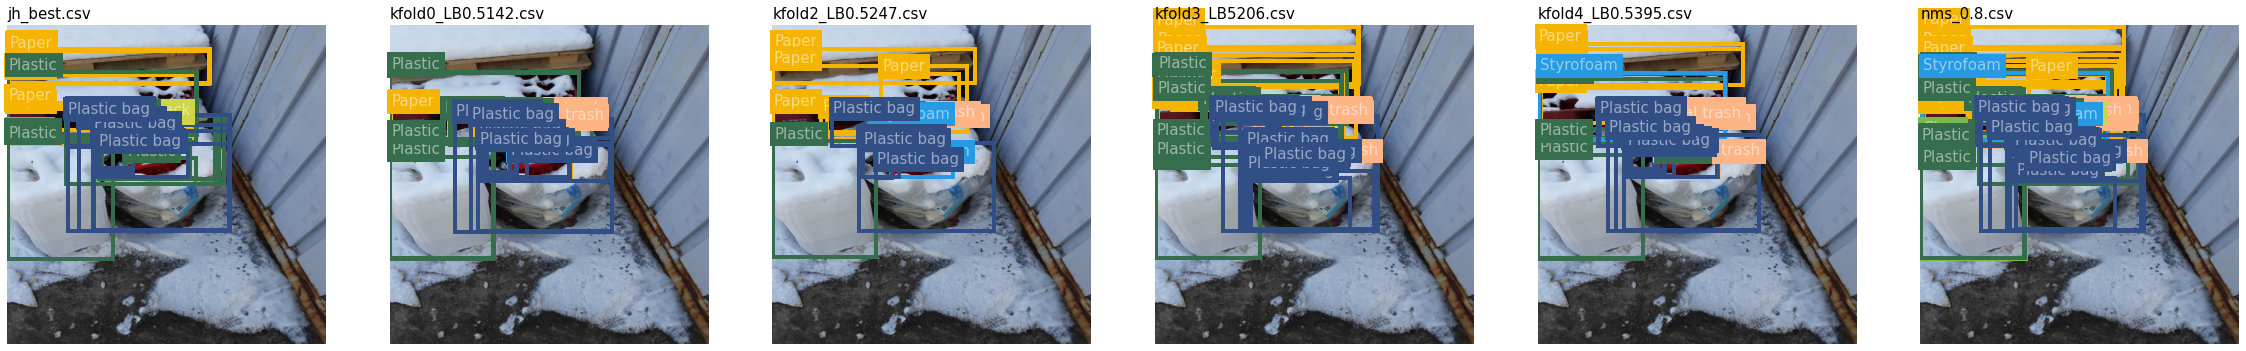

In [9]:
# original image with result
print_img(test_dir, image_ids, file_number, model_name, classes, color, submission_df, 20)

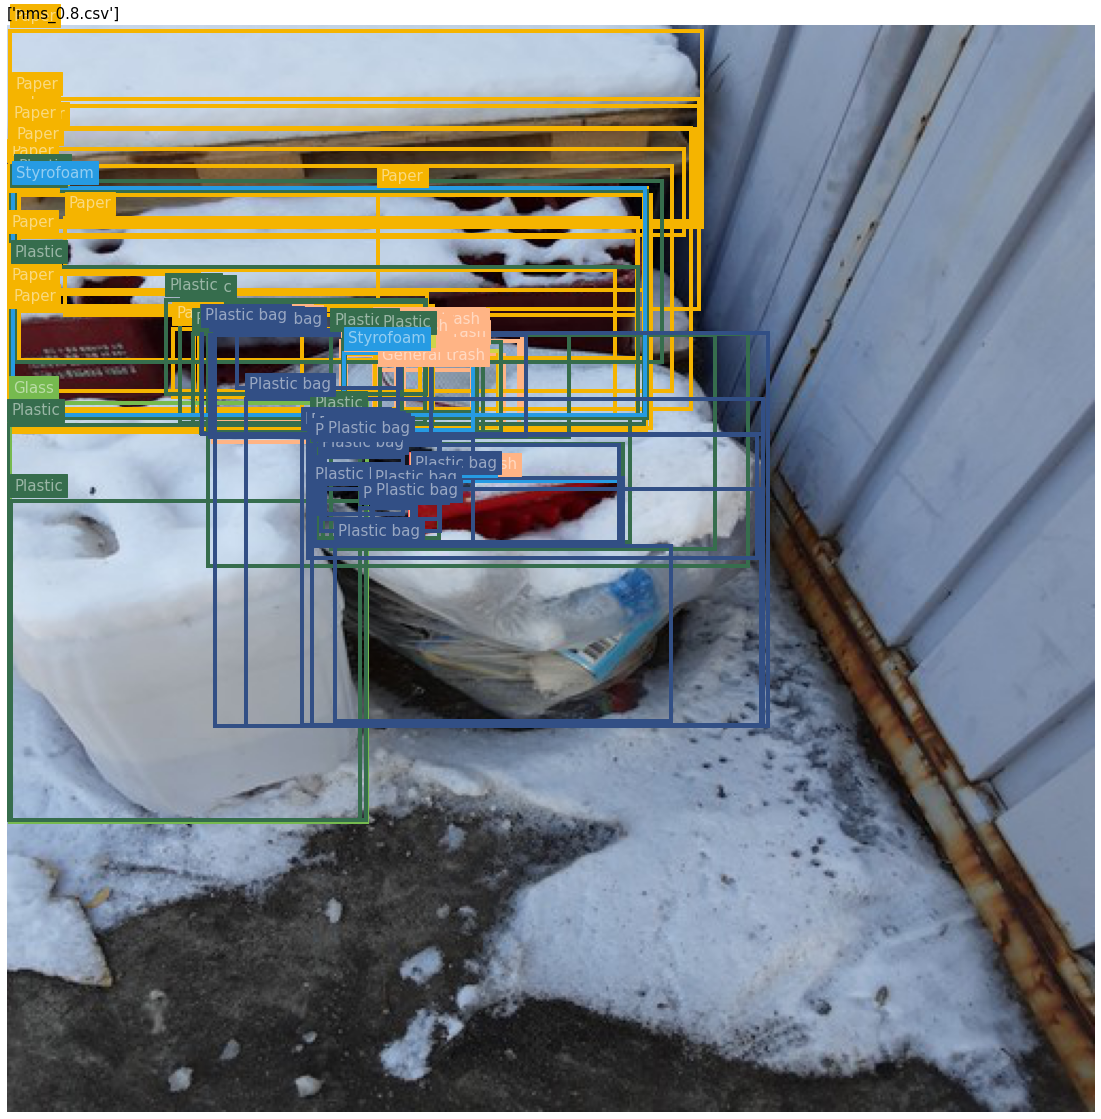

In [10]:
# result image
print_img(test_dir, image_ids, result_file_number, result_model_name, classes, color, result_df, 20)

In [11]:
def print_img(pred1, pred2, pred3, x):
    img_path = test_dir + pred1['image_id'][x]
#     test_img = cv2.imread(img_path)
    
    test_img = Image.open(img_path)
    img = np.array(test_img)
    
    info1 = pred1.iloc[x][0]
    info1 = info1[:-1]
    info2 = pred2.iloc[x][0]
    info2 = info2[:-1]
    info3 = pred3.iloc[x][0]
    info3 = info3[:-1]
    # def object_box(img, info):
    info1 = info1.split(" ")
    info2 = info2.split(" ")
    info3 = info3.split(" ")
    # info
    i = 0
    fig, axes = plt.subplots(nrows = 1, ncols = file_number, figsize = (40,20))
    
    while i < len(info1) and i < len(info2) and i < len(info3):
        label1 = int(info1[i])
        score1 = float(info1[i+1])
        x_min1 = float(info1[i+2])
        y_min1 = float(info1[i+3])
        x_max1 = float(info1[i+4])
        y_max1 = float(info1[i+5])
        
        label2 = int(info2[i])
        score2 = float(info2[i+1])
        x_min2 = float(info2[i+2])
        y_min2 = float(info2[i+3])
        x_max2 = float(info2[i+4])
        y_max2 = float(info2[i+5])
        
        label3 = int(info3[i])
        score3 = float(info3[i+1])
        x_min3 = float(info3[i+2])
        y_min3 = float(info3[i+3])
        x_max3 = float(info3[i+4])
        y_max3 = float(info3[i+5])
        ax1.imshow(img)
        ax1.axis('off')
        ax1.set_title(model1_name, loc='left', fontsize=15)
        ax1.add_patch(
             patches.Rectangle(
                (x_min1, y_min1),
                x_max1-x_min1,
                y_max1-y_min1,
                edgecolor = color[label1],
                facecolor = 'red',
                fill=False,
                linewidth=4, 
                alpha=1.0
             ))
        ax1.text(x_min1+1.5, y_min1-5.0, classes[label1], fontsize=15, color = 'white', backgroundcolor=color[label1], alpha=0.5)
        ax2.imshow(img)
        ax2.axis('off')
        ax2.set_title(model2_name, loc='left', fontsize=15)
        ax2.add_patch(
             patches.Rectangle(
                (x_min2, y_min2),
                x_max2-x_min2,
                y_max2-y_min2,
                edgecolor = color[label2],
                facecolor = 'red',
                fill=False,
                linewidth=4, 
                alpha=1.0
             ))
        ax2.text(x_min2+1.5, y_min2-5.0, classes[label2], fontsize=15, color = 'white', backgroundcolor=color[label2], alpha=0.5)
        ax3.imshow(img)
        ax3.axis('off')
        ax3.set_title('result', loc='left', fontsize=15)
        ax3.add_patch(
             patches.Rectangle(
                (x_min3, y_min3),
                x_max3-x_min3,
                y_max3-y_min3,
                edgecolor = color[label3],
                facecolor = 'red',
                fill=False,
                linewidth=4, 
                alpha=1.0
             ))
        ax3.text(x_min3+1.5, y_min3-5.0, classes[label3], fontsize=15, color = 'white', backgroundcolor=color[label3], alpha=0.5)
        i += 6
#         break
    plt.show()

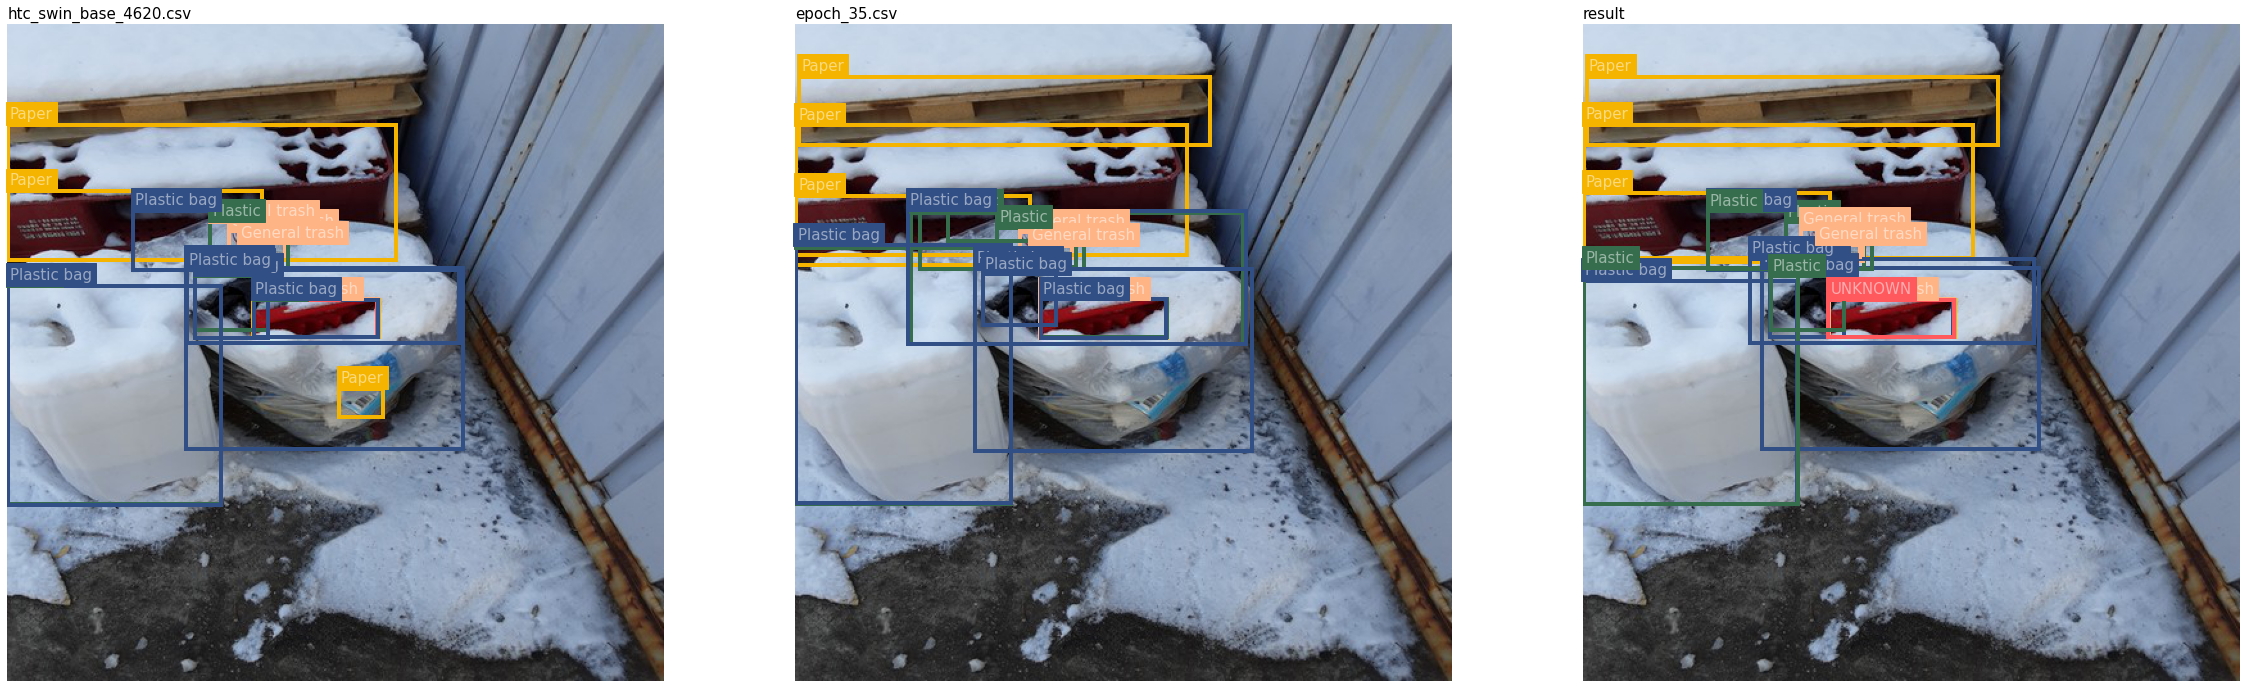

In [155]:
print_img(pred1, pred2, pred3, 20)

In [ ]:
# i = 0
# iou_thr = 0.5
# skip_box_thr = 0.0001
# sigma = 0.1
# weights = None
# boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
# boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
# boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
# boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)


# boxes, scores, labels = nms([boxes_list], [scores_list], [labels_list], weights=[0, 1], iou_thr=iou_thr)
# boxes, scores, labels = soft_nms([boxes_list], [scores_list], [labels_list], weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
# boxes, scores, labels = non_maximum_weighted([boxes_list], [scores_list], [labels_list], weights=weights, iou_thr=iou_thr, skip_box_thr=0.0)
# boxes, scores, labels = weighted_boxes_fusion(boxes_list], [scores_list], [labels_list], weights=weights, iou_thr=iou_thr, skip_box_thr=0.0)

In [ ]:
# whole_bbox = []
# whole_label = []
# whole_prop = []
# for k in range(len(image_bbox)):
#     img_bbox = []
#     label = []
#     prop = []
#     prediction_list = image_bbox[k].split()
#     i = 0
#     while i < len(prediction_list):
#         if i % 6 == 0:
#             bbox = []
#             label.append(int(prediction_list[i]))
#         elif i % 6 == 1:
#             prop.append(float(prediction_list[i]))
#         else:
#             bbox.append(float(prediction_list[i]))
#         i += 1
#         if i % 6 == 0:
#             img_bbox.append(bbox)
#     whole_bbox.append(list(img_bbox))
#     whole_label.append(list(label))
#     whole_prop.append(list(prop))